### Simple objective: branin with sleeps to emulate delay

In [85]:
# silence TF warnings and info messages, only print errors
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import numpy as np
import math

import time
import timeit

In [86]:
def objective(points, sleep=True):
    if points.shape[1] != 2:
        raise ValueError(f"Incorrect input shape, expected (*, 2), got {points.shape}")

    def scaled_branin(x):
        x0 = x[..., :1] * 15.0 - 5.0
        x1 = x[..., 1:] * 15.0

        b = 5.1 / (4 * math.pi ** 2)
        c = 5 / math.pi
        r = 6
        s = 10
        t = 1 / (8 * math.pi)
        scale = 1 / 51.95
        translate = -44.81

        if sleep:
            # insert some artificial delay
            # increases linearly with the absolute value of points
            # which means our evaluations will take different time, good for exploring async
            delay = 3 * np.sum(x)
            pid = os.getpid()
            print(f"Process {pid}: Objective: pretends like it's doing something for {delay:.2}s", flush=True)
            time.sleep(delay)
        
        return scale * ((x1 - b * x0 ** 2 + c * x0 - r) ** 2 + s * (1 - t) * np.cos(x0) + translate)
        
    observations = []
    for point in points:
        observation = scaled_branin(point)
        observations.append(observation)
    
    return np.array(observations)

In [87]:
objective(np.array([[0.1, 0.5]]), sleep=False)

array([[-0.42052567]])

## Here comes Trieste

First, define some initial data

In [88]:
from trieste.space import Box
from trieste.data import Dataset
from trieste.objectives import SCALED_BRANIN_MINIMUM

search_space = Box([0, 0], [1, 1])
num_initial_points = 3
initial_query_points = search_space.sample(num_initial_points)
initial_observations = objective(initial_query_points.numpy(), sleep=False)
initial_data = Dataset(query_points=initial_query_points, observations=tf.constant(initial_observations, dtype=tf.float64))

initial_data

Dataset(query_points=<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.66249635, 0.44241299],
       [0.07295593, 0.15001666],
       [0.85785476, 0.13421642]])>, observations=<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-0.27136373],
       [ 1.74658013],
       [-0.85953795]])>)

Model definition

In [89]:
import gpflow
from trieste.models import create_model

from trieste.models.gpflow.config import GPflowModelConfig

def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.RBF(variance=variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GPflowModelConfig(**{
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    })

We will be using LP function, let's define it

In [90]:
from trieste.acquisition import LocalPenalizationAcquisitionFunction
from trieste.acquisition.rule import EfficientGlobalOptimization

local_penalization_acq = LocalPenalizationAcquisitionFunction(search_space, num_samples=2000)

Testing out model and acq function

In [91]:
model_spec = build_model(initial_data)
model = create_model(model_spec)

local_penalization_acq_rule = EfficientGlobalOptimization(
    num_query_points=3, builder=local_penalization_acq)
points_chosen = local_penalization_acq_rule.acquire_single(search_space, initial_data, model)

print(points_chosen)

print(objective(points_chosen.numpy(), sleep=False))

tf.Tensor(
[[1.         0.27726267]
 [1.         0.37873432]
 [1.         0.17671412]], shape=(3, 2), dtype=float64)
[[-0.99192612]
 [-0.87959313]
 [-1.0152605 ]]


## Normal sync BO with LP

In [92]:
from trieste.bayesian_optimizer import BayesianOptimizer
from trieste.objectives.utils import mk_observer

observer = mk_observer(lambda x: objective(x, sleep=True))
bo = BayesianOptimizer(observer, search_space)

model_spec = build_model(initial_data)
model = create_model(model_spec)

local_penalization_acq = LocalPenalizationAcquisitionFunction(search_space, num_samples=2000)
local_penalization_rule = EfficientGlobalOptimization(
    num_query_points=3, builder=local_penalization_acq
)

start = timeit.default_timer()
local_penalization_result = bo.optimize(
    10, initial_data, model, acquisition_rule=local_penalization_rule
)
stop = timeit.default_timer()

sync_lp_observations = (
    local_penalization_result.try_get_final_dataset().observations - SCALED_BRANIN_MINIMUM
)

sync_lp_time = stop - start
print(f"Got {len(sync_lp_observations)} in {sync_lp_time:.2f}s")

Process 30745: Objective: pretends like it's doing something for 4.0s
Process 30745: Objective: pretends like it's doing something for 4.8s
Process 30745: Objective: pretends like it's doing something for 3.0s
Process 30745: Objective: pretends like it's doing something for 3.6s
Process 30745: Objective: pretends like it's doing something for 3.5s
Process 30745: Objective: pretends like it's doing something for 3.6s
Process 30745: Objective: pretends like it's doing something for 3.0s
Process 30745: Objective: pretends like it's doing something for 3.7s
Process 30745: Objective: pretends like it's doing something for 3.6s
Process 30745: Objective: pretends like it's doing something for 3.6s
Process 30745: Objective: pretends like it's doing something for 3.6s
Process 30745: Objective: pretends like it's doing something for 2.3s
Process 30745: Objective: pretends like it's doing something for 5.3s
Process 30745: Objective: pretends like it's doing something for 3.4s
Process 30745: Objec

## Async BO

In [93]:
import psutil

def observer_proc(points_queue, observations_queue, cpu_id):
    pid = os.getpid()
    
    current_process = psutil.Process()
    current_process.cpu_affinity([cpu_id])
    print(f"Process {pid}: set CPU to {cpu_id}", flush=True)
    
    while True:
        point_to_observe = points_queue.get()
        if (point_to_observe is None):
            return
        
        print(f"Process {pid}: Observer : observing data at point {point_to_observe}", flush=True)
        new_observation = objective(point_to_observe, sleep=True)
        new_data = (point_to_observe, new_observation)
        
        print(f"Process {pid}: Observer : observed data {new_data}", flush=True)

        observations_queue.put(new_data)

In [94]:
from multiprocessing import Process, Manager


num_workers = 2
num_observations = 30
dataset = initial_data

model_spec = build_model(initial_data)
model = create_model(model_spec)

model.optimize(initial_data)

local_penalization_acq = LocalPenalizationAcquisitionFunction(search_space, num_samples=2000)
local_penalization_acq_rule = EfficientGlobalOptimization(
    num_query_points=1, builder=local_penalization_acq)

m = Manager()
pq = m.Queue()
oq = m.Queue()

observer_processes = []
pending_points = tf.zeros([0, initial_query_points.shape[1]], dtype=tf.float64)

start = timeit.default_timer()
try:
    for i in range(psutil.cpu_count())[:num_workers]:
        observer_p = Process(target=observer_proc, args=(pq, oq, i))
        observer_p.daemon = True
        observer_p.start()

        observer_processes.append(observer_p)

    # init the queue with first batch of points
    for _ in range(num_workers):
        point_chosen = local_penalization_acq_rule.acquire_single(search_space, initial_data, model)
        pq.put(np.atleast_2d(point_chosen.numpy()))

        pending_points = tf.concat([pending_points, point_chosen], axis=0)

    while len(dataset) < len(initial_data) + num_observations:
        pid = os.getpid()
        
        try:
            new_data = oq.get_nowait()
            print(f"Process {pid}: Main     : received data {new_data}", flush=True)
        except:
            continue
        
        query_points = tf.constant(new_data[0], dtype=tf.float64)

        # generate a tensor that contains True value for rows that equal to query_point
        # False otherwise
        # then use it to delete rows from pending points
        mask = tf.reduce_any(tf.not_equal(pending_points, query_points), axis=1)
        pending_points = tf.boolean_mask(pending_points, mask)

        new_data = Dataset(query_points=query_points,
                           observations=tf.constant(new_data[1], dtype=tf.float64),
                          )
        dataset = dataset + new_data

        model.update(dataset)
        model.optimize(dataset)

        new_points = local_penalization_acq_rule.acquire_single(search_space, dataset, model, pending_points=pending_points)
        pending_points = tf.concat([pending_points, new_points], axis=0)
        new_points = new_points.numpy()
        print(f"Process {pid}: Main     : acquired point {new_points}", flush=True)
        for point in new_points:
            pq.put(np.atleast_2d(point))
finally:
    for prc in observer_processes:
        prc.terminate()
        prc.join()
        prc.close()
stop = timeit.default_timer()

async_lp_observations = dataset.observations - SCALED_BRANIN_MINIMUM

async_lp_time = stop - start
print(f"Got {len(async_lp_observations)} in {async_lp_time:.2f}s")

Process 4650: set CPU to 0
Process 4655: set CPU to 1
Process 4650: Observer : observing data at point [[1.         0.34970941]]
Process 4650: Objective: pretends like it's doing something for 4.0s
Process 4655: Observer : observing data at point [[1.         0.34970929]]
Process 4655: Objective: pretends like it's doing something for 4.0s
Process 4650: Observer : observed data (array([[1.        , 0.34970941]]), array([[-0.92083205]]))
Process 30745: Main     : received data (array([[1.        , 0.34970941]]), array([[-0.92083205]]))
Process 4655: Observer : observed data (array([[1.        , 0.34970929]]), array([[-0.92083221]]))
Process 30745: Main     : acquired point [[1. 0.]]
Process 4650: Observer : observing data at point [[1. 0.]]Process 30745: Main     : received data (array([[1.        , 0.34970929]]), array([[-0.92083221]]))

Process 4650: Objective: pretends like it's doing something for 3.0s
Process 30745: Main     : acquired point [[1.         0.09622286]]
Process 4655: 

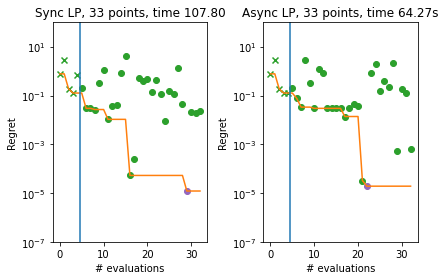

In [96]:
from trieste.objectives import SCALED_BRANIN_MINIMUM

from util.plotting import plot_regret
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

sync_lp_min_idx = tf.squeeze(tf.argmin(sync_lp_observations, axis=0))
async_lp_min_idx = tf.squeeze(tf.argmin(async_lp_observations, axis=0))

plot_regret(sync_lp_observations.numpy(), ax[0], num_init=5, idx_best=sync_lp_min_idx)
ax[0].set_yscale("log")
ax[0].set_ylabel("Regret")
ax[0].set_ylim(0.0000001, 100)
ax[0].set_xlabel("# evaluations")
ax[0].set_title(f"Sync LP, {len(sync_lp_observations)} points, time {sync_lp_time:.2f}")

plot_regret(async_lp_observations.numpy(), ax[1], num_init=5, idx_best=async_lp_min_idx)
ax[1].set_yscale("log")
ax[1].set_ylabel("Regret")
ax[1].set_ylim(0.0000001, 100)
ax[1].set_xlabel("# evaluations")
ax[1].set_title(f"Async LP, {len(async_lp_observations)} points, time {async_lp_time:.2f}s")

fig.tight_layout()